In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f160df8c-57ae-78ca-8984-99c36e267dfe)


In [2]:
# Get the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv

--2022-05-10 00:57:30--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50004 (49K) [text/plain]
Saving to: ‘daily_single.csv’

daily_single.csv    100%[===================>]  48.83K  --.-KB/s    in 0.001s  

2022-05-10 00:57:30 (41.6 MB/s) - ‘daily_single.csv’ saved [50004/50004]



In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_single.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(             Price
 Timestamp         
 2014-01-01  754.90
 2014-01-02  784.19
 2014-01-03  809.40
 2014-01-04  828.79
 2014-01-05  905.00,                Price
 Timestamp           
 2021-03-26  52734.30
 2021-03-27  54508.16
 2021-03-28  55871.93
 2021-03-29  57788.15
 2021-03-30  59069.29)

In [4]:
len(btc_df)

2236

In [5]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2236 entries, 2014-01-01 to 2021-03-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2236 non-null   float64
dtypes: float64(1)
memory usage: 34.9 KB


In [6]:
btc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2236.0,6692.873421,9291.712386,191.0,588.5375,4563.135,9107.615,60095.59


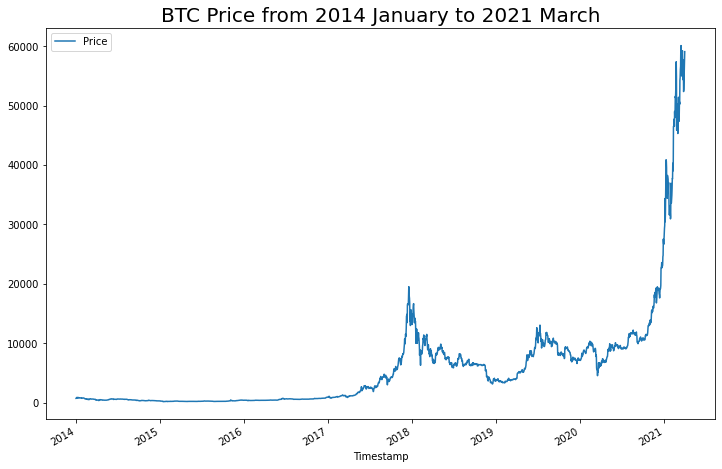

In [8]:
import matplotlib.pyplot as plt
btc_df.plot(figsize = (12,8))
plt.title("BTC Price from 2014 January to 2021 March", fontsize=20);
# ';' is put at last to remove unnecessary text from being displayed

In [9]:
btc_df.index.to_numpy()

array(['2014-01-01T00:00:00.000000000', '2014-01-02T00:00:00.000000000',
       '2014-01-03T00:00:00.000000000', ...,
       '2021-03-28T00:00:00.000000000', '2021-03-29T00:00:00.000000000',
       '2021-03-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
# Makes arrays for each feature
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()
boundary = int(0.8 * len(prices)) # 80% train, 20% test
X_train, y_train = timesteps[:boundary], prices[:boundary]
X_test, y_test = timesteps[boundary:], prices[boundary:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1788, 448, 1788, 448)

In [11]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

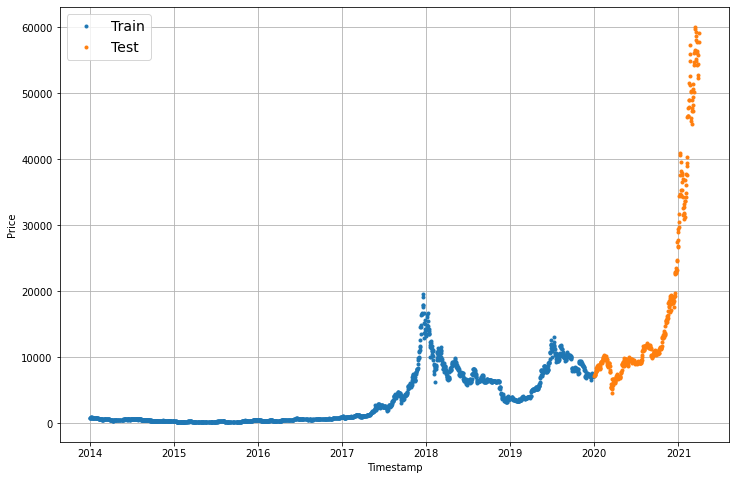

In [12]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, y_train, label= "Train")
plot_time_series(X_test, y_test, label = "Test")
# It would be interesting to put start and end as the year

In [13]:
# a = [1,2,3,4]
# a, a[:-1]

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [14]:
naive_forecast = y_test[:-1] # Gets every value excluding the last value
# naive_forecast[-10:] != y_test[-10:]

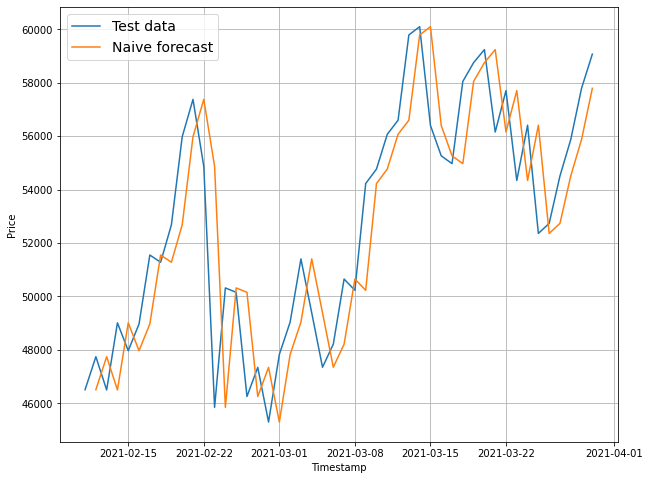

In [17]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = 400
plot_time_series(timesteps=X_test, values=y_test, start = 400, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start = 400, format="-", label="Naive forecast");

In [18]:
# Let's get TensorFlow! 
import tensorflow as tf

In [19]:
def mase_(y_true, y_pred):
  # Assuming no seasonality and our crypto price data has no seasonality
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:], naive_forecast)) # naive_forecast = y_true[:-1]
  return mae/mae_naive

In [20]:
# mase(y_true=y_test[1:], y_pred= naive_forecast).numpy() #should be close to 1

In [21]:
# type(y_test[0]),y_test[0].dtype
# Numpy is float64 datatype as default so we need to convert to float32 datatype while using tensorflow

In [22]:
# returns error metrics in dictionary form:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  "mase": mase.numpy()
                  }
  return return_dict

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2804}

In [24]:
tf.reduce_mean(y_test).numpy()

17809.185937500002

In [25]:
# Windowing dataset to turn our data into supervised learning problem by giving labels
# Global variables are usually put with capital letters
# Using previous 7 days data to predict the price of 1 day
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# a=[1,2,3,4,5]
# a[:, :-1]
a = tf.expand_dims(tf.range(8)+1, axis=0)[:, :-1]
print(a)
tf.squeeze(a).numpy()

tf.Tensor([[1 2 3 4 5 6 7]], shape=(1, 7), dtype=int32)


array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [27]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We need to do the above on our entire btc data. For doing it, using python for loops is good but it becomes very slow when using it in python for-loops so we are using numpy index.

In [29]:
# make windows from numpy arrays
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the windoe_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels

    # a = np.array([1,2,3,4])
    # x = np.array([10,11,12,13,14])
    # a, x, x[a]

In [37]:
# Passing the whole dataset in the windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)
print("Full_windows: \n", full_windows[:3])
print("Full_labels: \n", full_labels[:3])

Full_windows: 
 [[754.9  784.19 809.4  828.79 905.   919.24 785.  ]
 [784.19 809.4  828.79 905.   919.24 785.   824.76]
 [809.4  828.79 905.   919.24 785.   824.76 852.61]]
Full_labels: 
 [[824.76]
 [852.61]
 [896.59]]


In [31]:
def make_train_test_splits(windows, labels, test_split = 0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  # returns in the same order as skit-learn splitting function returns
  return train_windows, test_windows, train_labels, test_labels

In [32]:
# Create a train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [38]:
len(train_labels[:-HORIZON]), len(train_labels), len(train_labels[:-HORIZON-1]), len(y_train), len(y_train[WINDOW_SIZE:])

(1782, 1783, 1781, 1788, 1781)

In [39]:
train_labels[:5], tf.squeeze(train_labels[:5]).numpy()

(array([[824.76],
        [852.61],
        [896.59],
        [844.05],
        [823.  ]]), array([824.76, 852.61, 896.59, 844.05, 823.  ]))

In [40]:
# len(tf.keras.preprocessing.timeseries_dataset_from_array(data =prices, targets = None, sequence_length=7, sampling_rate=1, sequence_stride=1, shuffle=False))

In [41]:
# Make the train/test splits
# Our approach is to window the data first and then make tests/train splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [42]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1783, 446, 1783, 446)

In [47]:
train_windows

array([[ 754.9 ,  784.19,  809.4 , ...,  905.  ,  919.24,  785.  ],
       [ 784.19,  809.4 ,  828.79, ...,  919.24,  785.  ,  824.76],
       [ 809.4 ,  828.79,  905.  , ...,  785.  ,  824.76,  852.61],
       ...,
       [7208.69, 7181.73, 7133.65, ..., 7326.  , 7298.62, 7222.11],
       [7181.73, 7133.65, 7284.59, ..., 7298.62, 7222.11, 7171.68],
       [7133.65, 7284.59, 7326.  , ..., 7222.11, 7171.68, 7129.2 ]])

In [48]:
# os is imported to save the model's best performance in google colab
import os
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [49]:
""" 
  Model-1: Dense model (window=7, horizon=1)
  The values are chosen by doing experiments
"""

import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='linear') # Same output as it was passed into it (similar to no activation)
], name='model_1_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # saves the best model



Epoch 1/100
14/14 [==============================] - 3s 51ms/step - loss: 1101.4684 - mae: 1101.4684 - mse: 3685982.0000 - val_loss: 1823.5269 - val_mae: 1823.5269 - val_mse: 7447299.5000
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 364.8582 - mae: 364.8582 - mse: 455576.5312 - val_loss: 1636.1923 - val_mae: 1636.1923 - val_mse: 6570599.5000
Epoch 3/100
14/14 [==============================] - 0s 31ms/step - loss: 262.0759 - mae: 262.0759 - mse: 276247.6875 - val_loss: 910.5290 - val_mae: 910.5290 - val_mse: 2657821.0000
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 229.8432 - mae: 229.8432 - mse: 223029.6250 - val_loss: 871.9883 - val_mae: 871.9883 - val_mse: 2471781.2500
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 213.3530 - mae: 213.3530 - mse: 196829.2969 - val_loss: 934.7551 - val_mae: 934.7551 - val_mse: 2760926.2500
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 209.71

In [50]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)
# This is not the model's best performance, it is the last epoch's performance

14/14 [==============================] - 0s 3ms/step - loss: 571.8756 - mae: 571.8756 - mse: 1358415.5000


[571.8756103515625, 571.8756103515625, 1358415.5]

In [51]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("models/model_1_dense")
model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 563.8818 - mae: 563.8818 - mse: 1339607.5000


[563.8818359375, 563.8818359375, 1339607.5]

Ateps for making a forecast on the test dataset:
* Take in a train model
* Take in some input data (same kind of data the model was trained on)
* Passes the input data to the model's `predict()` method
* Returns the predictions

In [52]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [53]:
# Make predictions using model_1 on the test dataset and evaluate it on test data
# Because of the model1 checkpoint, we are getting the predictions from the best performing model
model_1_prediction = make_prediction(model_1, test_windows)
len(model_1_prediction), model_1_prediction[:10]

(446, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7325.8174, 7375.14  , 7473.6387, 7583.597 , 7968.2456, 8359.743 ,
        8034.2095, 7894.657 , 8068.1987, 8165.164 ], dtype=float32)>)

The most common errors in machine learning is the input and output size

In [54]:
test_labels.shape, model_1_prediction.shape, tf.squeeze(test_labels).shape

((446, 1), TensorShape([446]), TensorShape([446]))

In [55]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)
model_1_results

{'mae': 563.8818,
 'mape': 2.7862234,
 'mase': 0.99867654,
 'mse': 1339607.5,
 'rmse': 1157.4142}

In [ ]:
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2805}

In [56]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [57]:
a = [1,2,3,4]
a[-2:]

[3, 4]

In [58]:
len(X_test), len(test_windows)

(448, 446)

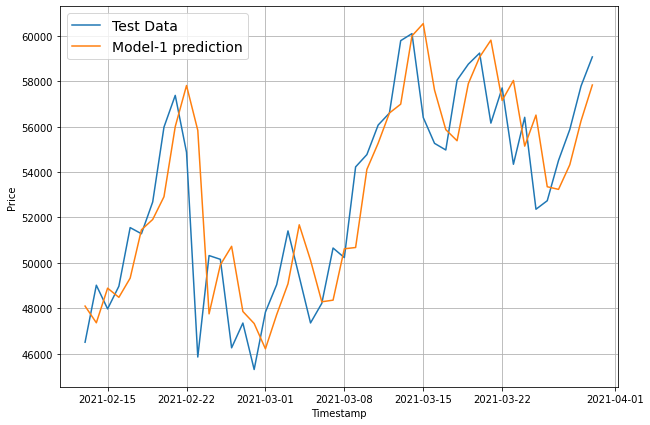

In [59]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=400
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_prediction, start=offset, label="Model-1 prediction", format='-')

In [60]:
# [:,0] means get every rows and get the zeroth dimenstion

In [61]:
# Autoregressive data is the reason for our prediction coming after the actual value

### We can make a large horizon predictions (like a week prediction) and later use either mean metric or any other to make a one prediciton

In [62]:
# Instead of prediction the exact prediction point, we can predict the prediction direction or prediction intervals like 99% prediction interval

In [63]:
## Model-2: Dense (Windows:30, Horizon:1)
HORIZON=1
WINDOW_SIZE=30

In [64]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2206, 2206)

In [65]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1764, 442, 1764, 442)

In [66]:
train_windows[:3]

array([[754.9 , 784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76,
        852.61, 896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07,
        826.02, 812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99,
        803.  , 814.99, 782.33, 763.99, 705.01, 680.49],
       [784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61,
        896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02,
        812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  ,
        814.99, 782.33, 763.99, 705.01, 680.49, 687.81],
       [809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61, 896.59,
        844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02, 812.  ,
        780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  , 814.99,
        782.33, 763.99, 705.01, 680.49, 687.81, 675.1 ]])

In [67]:
len(prices)

2236

In [68]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="relu")
], name="model_2_dense")

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
14/14 [==============================] - 1s 39ms/step - loss: 1372.0996 - val_loss: 5363.8169
Epoch 2/100
14/14 [==============================] - 1s 47ms/step - loss: 606.1738 - val_loss: 3543.5481
Epoch 3/100
14/14 [==============================] - 0s 31ms/step - loss: 472.0771 - val_loss: 1521.0830
Epoch 4/100
14/14 [==============================] - 0s 29ms/step - loss: 311.1849 - val_loss: 1250.7548
Epoch 5/100
14/14 [==============================] - 0s 32ms/step - loss: 254.1111 - val_loss: 1091.2778
Epoch 6/100
14/14 [==============================] - 0s 32ms/step - loss: 237.3476 - val_loss: 1027.5642
Epoch 7/100
14/14 [==============================] - 0s 32ms/step - loss: 229.6923 - val_loss: 941.8698
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 233.8298 - val_loss: 1318.6440
Epoch 9/100
14/14 [==============================] - 0s 5ms/step - loss: 243.0570 - val_loss: 1126.8374
Epoch 10/100
14/14 [==============================] - 0s 

In [69]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 597.4155


597.41552734375

In [70]:
model_2 = tf.keras.models.load_model("models/model_2_dense")
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 597.4155


597.41552734375

In [71]:
# Get the forecast predictions
model_2_prediction = make_prediction(model=model_2, input_data=test_windows)

In [72]:
# Evaluate the results for model-2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_prediction)
model_2_results

{'mae': 597.4155,
 'mape': 2.8864303,
 'mase': 0.9987878,
 'mse': 1448183.2,
 'rmse': 1203.4048}

In [ ]:
model_1_results

{'mae': 563.88196,
 'mape': 2.7862256,
 'mase': 0.99867654,
 'mse': 1339608.1,
 'rmse': 1157.4144}

In [ ]:
# Task is to make a for-loop and create a 30 different models with 1-30 window size and check which one performs best with the horizon of 1.

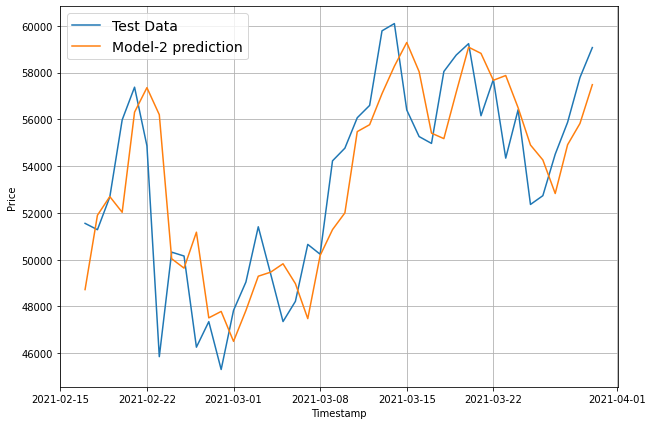

In [ ]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_prediction, format="-", start=offset, label="Model-2 prediction")

## Model predictions are lagging the test data trend

## Model 3: Dense (Window =30, Horizon =7)

In [73]:
HORIZON =7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2200, 2200)

In [74]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1760, 440, 1760, 440)

In [75]:
tf.random.set_seed(42)

# Create model (same as model_1 except the different data input and output size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = "model_3_dense")

# Compile
model_3.compile(loss="MAE", optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense/assets
INFO:tensorflow:Assets written to: models/model_3_dense

In [76]:
# Evaluate the model on the test data
model_3.evaluate(x = test_windows, y=test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 1179.1359


1179.1358642578125

In [77]:
# Load the best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("models/model_3_dense")
model_3.evaluate(x = test_windows, y=test_labels)
"""
  Here the errors are high compared to the other models
  But, since we are predicting the price for 7 days, the
  errors for all the days are added up to give higher value

"""

14/14 [==============================] - 0s 2ms/step - loss: 1166.3425


'\n  Here the errors are high compared to the other models\n  But, since we are predicting the price for 7 days, the\n  errors for all the days are added up to give higher value\n\n'

In [78]:
# Make predictions with model_3
model_3_prediction = make_prediction(model_3, input_data=test_windows)
model_3_prediction[:2]

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[7365.3643, 7369.7153, 7447.778 , 7252.211 , 7160.964 , 7343.4834,
        7212.922 ],
       [7439.1523, 7359.6763, 7445.0996, 7353.797 , 7180.5146, 7377.649 ,
        7281.506 ]], dtype=float32)>

In [79]:
model_3_prediction.shape, model_2_prediction.shape

(TensorShape([440, 7]), TensorShape([442]))

In [80]:
# Make our evaluation function work for larger horizons
# returns error metrics in dictionary form:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_(y_true, y_pred)
  
  # Account for different size metrics for longer horizons, we want to
  # reduce metrics to a single value
  if mae.ndim >0:
    # Aggregating the model_3 mae results to a single value just like tensorflow does
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  "mase": mase.numpy()
                  }
  return return_dict

In [81]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_prediction)
model_3_results

{'mae': 1166.3427,
 'mape': 5.943362,
 'mase': 0.99872345,
 'mse': 4639058.5,
 'rmse': 1351.1919}

In [82]:
model_3_prediction

<tf.Tensor: shape=(440, 7), dtype=float32, numpy=
array([[ 7365.3643,  7369.7153,  7447.778 , ...,  7160.964 ,  7343.4834,
         7212.922 ],
       [ 7439.1523,  7359.6763,  7445.0996, ...,  7180.5146,  7377.649 ,
         7281.506 ],
       [ 7539.6426,  7516.575 ,  7526.529 , ...,  7351.826 ,  7478.5723,
         7311.8237],
       ...,
       [58004.27  , 59421.184 , 60418.01  , ..., 57905.1   , 59278.92  ,
        60419.336 ],
       [58482.434 , 57751.77  , 59060.043 , ..., 57082.094 , 56592.934 ,
        57142.938 ],
       [56646.44  , 56851.457 , 57310.023 , ..., 53946.746 , 56224.4   ,
        55596.734 ]], dtype=float32)>

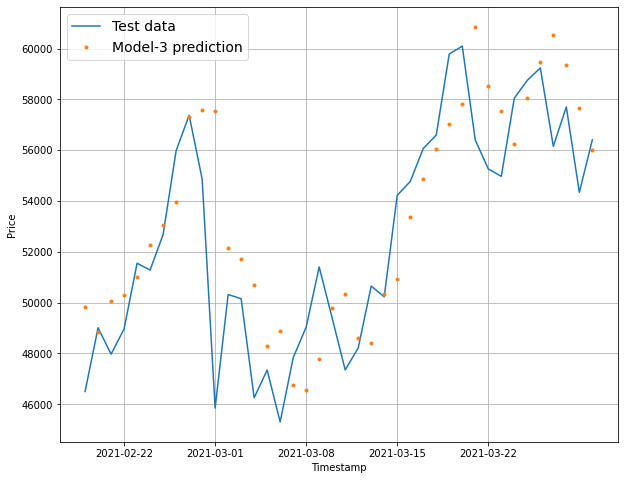

In [83]:
plt.figure(figsize=(10, 8))
offset = 400
plot_time_series(timesteps=X_test[-len(test_windows):], values = test_labels[:, 0], start=offset, format = "-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values= tf.reduce_mean(model_3_prediction, axis = 1), start=offset, label="Model-3 prediction")

### Usually, to visualize we need to reduce the dimension. But, I think I can make more accurate prediction by getting the prediction value of that day from each arrays

## Comparing models

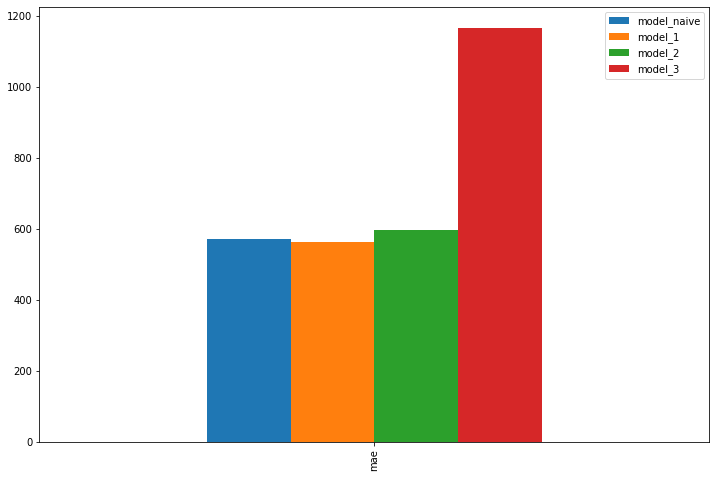

In [84]:
pd.DataFrame({"model_naive": naive_results["mae"],
              "model_1": model_1_results["mae"],
              "model_2": model_2_results["mae"],
              "model_3": model_3_results["mae"]
              }, index = ["mae"]).plot(figsize=(12,8), kind="bar")

# Naive model gives the good results because the bitcoin dataset is also a auto-correlated data; Timeseries follow significant autocorrelation.

### The models are not CNN, maybe they are Recurrent Neural Networks (RNN)

## Model-4: Conv1D

In [85]:
HORIZON = 1
WINDOW_SIZE = 7


In [86]:
prices

array([  754.9 ,   784.19,   809.4 , ..., 55871.93, 57788.15, 59069.29])

In [87]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2229, 2229)

In [88]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

Tensorflow conv1D model uses temporal convolution.
We need an input shape of: `(batch_size, timesteps, input_dim)`

In [89]:
# Current input shape of our data
# which means one sample of training window
# input_dim should be one because we want our model to use 1 week of data to predict 1 horizon at a time
train_windows[0].shape

(7,)

In [90]:
# Before we pass our data to the conv1D layer, reshaping it:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=array([754.9 , 784.19, 809.4 , 828.79, 905.  , 919.24, 785.  ])>

In [91]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input dim
# Instead of doing tf.expand_dims() directly, we are using lambda layers and the benefit of doing this
# is that we can add this to a model

In [92]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[754.9 ]
 [784.19]
 [809.4 ]
 [828.79]
 [905.  ]
 [919.24]
 [785.  ]]


In [93]:
# Adjustments: 1000 epochs, 256 filters (multiples of 8)
# Create model_4


tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
  # expand_dims_layer
  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            train_labels, 
            batch_size=128, 
            epochs=100, 
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)]
            )

INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: models/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model

In [ ]:
# train_windows, tf.stack(train_windows)

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            9216      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              257       
                                                                 
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [95]:
model_4.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 563.0298


563.02978515625

In [96]:
model_4 = tf.keras.models.load_model("models/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 563.0298


563.02978515625

In [97]:
# Model predictions
model_4_preds = make_prediction(model_4, test_windows)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([7327.7354, 7379.137 , 7467.457 , 7580.364 , 7953.032 ],
      dtype=float32)>

In [98]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 563.0298,
 'mape': 2.7528427,
 'mase': 0.99867654,
 'mse': 1327197.0,
 'rmse': 1152.0403}

In [ ]:
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2805}

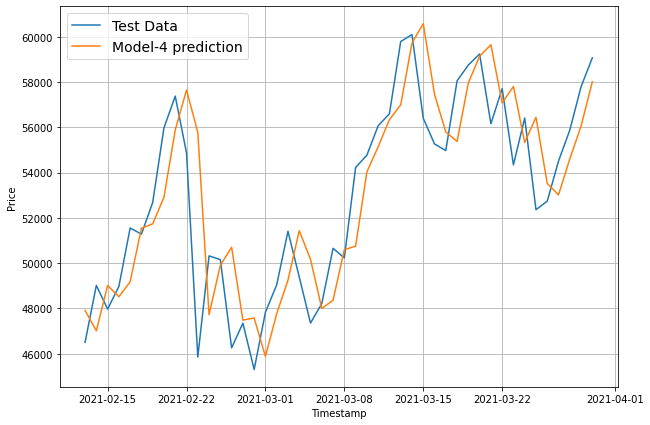

In [118]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, format="-", start=offset, label="Model-4 prediction")

# Model 5: RNN (LSTM)

In [99]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.LSTM(128, activation="relu")(x) # default activation function is "tanx"
# One of the way of improving the accuracy of neural network is adding more layers
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)]
            )



Epoch 1/100
10/14 [====================>.........] - ETA: 0s - loss: 3357.8757 INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 165ms/step - loss: 3095.0969 - val_loss: 10997.6348
Epoch 2/100
11/14 [======================>.......] - ETA: 0s - loss: 1784.3214INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 128ms/step - loss: 1626.9008 - val_loss: 3911.0088
Epoch 3/100
12/14 [========================>.....] - ETA: 0s - loss: 400.6266INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 123ms/step - loss: 403.4806 - val_loss: 1469.0134
Epoch 4/100
12/14 [========================>.....] - ETA: 0s - loss: 301.9387INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 121ms/step - loss: 290.4884 - val_loss: 1212.0911
Epoch 5/100
12/14 [========================>.....] - ETA: 0s - loss: 228.2712INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 149ms/step - loss: 229.8724 - val_loss: 869.4640
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 213.5283 - val_loss: 1007.1722
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 214.5539 - val_loss: 916.8719
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 210.3837 - val_loss: 929.8438
Epoch 9/100
14/14 [==============================] - 0s 16ms/step - loss: 209.0407 - val_loss: 894.3557
Epoch 10/100
14/14 [==============================] - 0s 13ms/step - loss: 208.1452 - val_loss: 947.1334
Epoch 11/100
14/14 [==============================] - 0s 15ms/step - loss: 207.1694 - val_loss: 873.8168
Epoch 12/100
14/14 [==============================] - 0s 11ms/step - loss: 205.8418 - val_loss: 876.9938
Epoch 13/100
12/14 [========================>.....] - ETA: 0s - loss: 209.9911INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 4s 330ms/step - loss: 204.5708 - val_loss: 861.7523
Epoch 14/100
14/14 [==============================] - 0s 14ms/step - loss: 203.4718 - val_loss: 884.7315
Epoch 15/100
14/14 [==============================] - 0s 16ms/step - loss: 203.0755 - val_loss: 903.8788
Epoch 16/100
14/14 [==============================] - 0s 11ms/step - loss: 199.9152 - val_loss: 867.3812
Epoch 17/100
14/14 [==============================] - 0s 16ms/step - loss: 198.5207 - val_loss: 868.9608
Epoch 18/100
14/14 [==============================] - 0s 12ms/step - loss: 197.4298 - val_loss: 869.5586
Epoch 19/100
13/14 [==========================>...] - ETA: 0s - loss: 199.8171INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 4s 275ms/step - loss: 196.5982 - val_loss: 847.4627
Epoch 20/100
12/14 [========================>.....] - ETA: 0s - loss: 197.4993INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 232ms/step - loss: 194.8521 - val_loss: 807.9312
Epoch 21/100
14/14 [==============================] - 0s 7ms/step - loss: 193.5974 - val_loss: 833.2915
Epoch 22/100
14/14 [==============================] - 0s 7ms/step - loss: 192.1645 - val_loss: 851.9040
Epoch 23/100
10/14 [====================>.........] - ETA: 0s - loss: 195.4410INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 123ms/step - loss: 190.3922 - val_loss: 806.0174
Epoch 24/100
11/14 [======================>.......] - ETA: 0s - loss: 190.4501INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 124ms/step - loss: 191.2002 - val_loss: 776.3761
Epoch 25/100
14/14 [==============================] - 0s 7ms/step - loss: 189.2732 - val_loss: 789.4395
Epoch 26/100
14/14 [==============================] - 0s 7ms/step - loss: 185.4485 - val_loss: 826.9141
Epoch 27/100
12/14 [========================>.....] - ETA: 0s - loss: 182.2892INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 121ms/step - loss: 180.7771 - val_loss: 720.4572
Epoch 28/100
12/14 [========================>.....] - ETA: 0s - loss: 178.6579INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 147ms/step - loss: 177.3669 - val_loss: 702.2065
Epoch 29/100
14/14 [==============================] - 0s 7ms/step - loss: 200.3021 - val_loss: 801.3125
Epoch 30/100
14/14 [==============================] - 0s 7ms/step - loss: 185.9404 - val_loss: 766.1491
Epoch 31/100
14/14 [==============================] - 0s 9ms/step - loss: 180.4454 - val_loss: 748.2368
Epoch 32/100
14/14 [==============================] - 0s 8ms/step - loss: 178.5164 - val_loss: 738.5284
Epoch 33/100
14/14 [==============================] - 0s 7ms/step - loss: 176.6198 - val_loss: 817.3337
Epoch 34/100
14/14 [==============================] - 0s 7ms/step - loss: 175.6466 - val_loss: 801.8495
Epoch 35/100
14/14 [==============================] - 0s 7ms/step - loss: 173.6287 - val_loss: 758.5744
Epoch 36/100
14/14 [==============================] - 0s 7ms/step - loss: 171.5962 - val_loss: 772.8607
Epoch 37/100
14/14 [==============================] - 0s 8ms/step - loss: 1

INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 125ms/step - loss: 168.9908 - val_loss: 686.8840
Epoch 45/100
10/14 [====================>.........] - ETA: 0s - loss: 178.1078INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 126ms/step - loss: 169.3746 - val_loss: 671.9968
Epoch 46/100
12/14 [========================>.....] - ETA: 0s - loss: 168.6537INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 122ms/step - loss: 162.2892 - val_loss: 667.8841
Epoch 47/100
14/14 [==============================] - 0s 8ms/step - loss: 159.5396 - val_loss: 690.8059
Epoch 48/100
14/14 [==============================] - 0s 7ms/step - loss: 157.0992 - val_loss: 714.4670
Epoch 49/100
12/14 [========================>.....] - ETA: 0s - loss: 157.7953INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 150ms/step - loss: 156.7978 - val_loss: 655.0980
Epoch 50/100
10/14 [====================>.........] - ETA: 0s - loss: 162.6544INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 125ms/step - loss: 160.2476 - val_loss: 652.5286
Epoch 51/100
14/14 [==============================] - 0s 7ms/step - loss: 155.8842 - val_loss: 653.9545
Epoch 52/100
 9/14 [==================>...........] - ETA: 0s - loss: 156.2282INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 125ms/step - loss: 154.2570 - val_loss: 649.9645
Epoch 53/100
12/14 [========================>.....] - ETA: 0s - loss: 152.0563INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 143ms/step - loss: 153.7128 - val_loss: 647.3256
Epoch 54/100
11/14 [======================>.......] - ETA: 0s - loss: 154.2684INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 126ms/step - loss: 152.9613 - val_loss: 645.4499
Epoch 55/100
14/14 [==============================] - 0s 7ms/step - loss: 151.5489 - val_loss: 646.0309
Epoch 56/100
14/14 [==============================] - 0s 7ms/step - loss: 150.9307 - val_loss: 665.4194
Epoch 57/100
14/14 [==============================] - 0s 8ms/step - loss: 150.2966 - val_loss: 658.2276
Epoch 58/100
11/14 [======================>.......] - ETA: 0s - loss: 151.5116INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 124ms/step - loss: 150.5427 - val_loss: 635.2477
Epoch 59/100
14/14 [==============================] - 0s 8ms/step - loss: 148.5207 - val_loss: 659.7517
Epoch 60/100
14/14 [==============================] - 0s 8ms/step - loss: 148.5474 - val_loss: 699.8357
Epoch 61/100
14/14 [==============================] - 0s 7ms/step - loss: 148.6339 - val_loss: 640.8012
Epoch 62/100
14/14 [==============================] - 0s 7ms/step - loss: 147.6112 - val_loss: 635.9682
Epoch 63/100
14/14 [==============================] - 0s 7ms/step - loss: 146.9446 - val_loss: 651.4786
Epoch 64/100
12/14 [========================>.....] - ETA: 0s - loss: 148.7262INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 122ms/step - loss: 146.8891 - val_loss: 624.9724
Epoch 65/100
14/14 [==============================] - 0s 7ms/step - loss: 147.9570 - val_loss: 685.9843
Epoch 66/100
14/14 [==============================] - 0s 7ms/step - loss: 145.6583 - val_loss: 641.8665
Epoch 67/100
12/14 [========================>.....] - ETA: 0s - loss: 142.5473INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 144ms/step - loss: 146.0368 - val_loss: 621.8424
Epoch 68/100
14/14 [==============================] - 0s 7ms/step - loss: 146.7643 - val_loss: 652.1618
Epoch 69/100
14/14 [==============================] - 0s 7ms/step - loss: 146.1160 - val_loss: 630.1522
Epoch 70/100
12/14 [========================>.....] - ETA: 0s - loss: 141.1957INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 121ms/step - loss: 147.3013 - val_loss: 616.3434
Epoch 71/100
12/14 [========================>.....] - ETA: 0s - loss: 152.1795INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 123ms/step - loss: 153.1615 - val_loss: 615.7501
Epoch 72/100
14/14 [==============================] - 0s 7ms/step - loss: 155.3015 - val_loss: 673.6427
Epoch 73/100
14/14 [==============================] - 0s 8ms/step - loss: 147.5294 - val_loss: 667.4606
Epoch 74/100
14/14 [==============================] - 0s 8ms/step - loss: 144.3259 - val_loss: 623.6088
Epoch 75/100
12/14 [========================>.....] - ETA: 0s - loss: 143.7967INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 145ms/step - loss: 143.5679 - val_loss: 612.1233
Epoch 76/100
14/14 [==============================] - 0s 8ms/step - loss: 143.5831 - val_loss: 621.3458
Epoch 77/100
14/14 [==============================] - 0s 7ms/step - loss: 142.8464 - val_loss: 619.2380
Epoch 78/100
12/14 [========================>.....] - ETA: 0s - loss: 139.6149INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 123ms/step - loss: 143.3759 - val_loss: 608.2902
Epoch 79/100
14/14 [==============================] - 0s 7ms/step - loss: 143.0520 - val_loss: 614.0176
Epoch 80/100
14/14 [==============================] - 0s 7ms/step - loss: 141.5308 - val_loss: 610.1227
Epoch 81/100
14/14 [==============================] - 0s 7ms/step - loss: 141.8572 - val_loss: 626.2983
Epoch 82/100
14/14 [==============================] - 0s 8ms/step - loss: 141.1483 - val_loss: 618.3404
Epoch 83/100
14/14 [==============================] - 0s 7ms/step - loss: 140.9981 - val_loss: 610.1553
Epoch 84/100
 9/14 [==================>...........] - ETA: 0s - loss: 142.0237INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 121ms/step - loss: 141.2170 - val_loss: 605.6880
Epoch 85/100
14/14 [==============================] - 0s 8ms/step - loss: 141.6239 - val_loss: 672.9080
Epoch 86/100
14/14 [==============================] - 0s 7ms/step - loss: 141.4875 - val_loss: 623.3575
Epoch 87/100
12/14 [========================>.....] - ETA: 0s - loss: 145.0857INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 119ms/step - loss: 140.4497 - val_loss: 604.8954
Epoch 88/100
14/14 [==============================] - 0s 7ms/step - loss: 140.4147 - val_loss: 640.0852
Epoch 89/100
11/14 [======================>.......] - ETA: 0s - loss: 148.2961INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 150ms/step - loss: 142.0560 - val_loss: 601.2917
Epoch 90/100
14/14 [==============================] - 0s 7ms/step - loss: 140.8751 - val_loss: 612.8365
Epoch 91/100
14/14 [==============================] - 0s 8ms/step - loss: 139.9382 - val_loss: 604.1486
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 142.5656 - val_loss: 707.6750
Epoch 93/100
11/14 [======================>.......] - ETA: 0s - loss: 152.1307INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 125ms/step - loss: 146.3547 - val_loss: 599.6319
Epoch 94/100
14/14 [==============================] - 0s 7ms/step - loss: 139.5687 - val_loss: 600.4816
Epoch 95/100
14/14 [==============================] - 0s 8ms/step - loss: 138.4352 - val_loss: 612.8209
Epoch 96/100
11/14 [======================>.......] - ETA: 0s - loss: 130.6992INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 121ms/step - loss: 138.0334 - val_loss: 597.4940
Epoch 97/100
14/14 [==============================] - 0s 7ms/step - loss: 139.9027 - val_loss: 636.2718
Epoch 98/100
11/14 [======================>.......] - ETA: 0s - loss: 136.5389INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 123ms/step - loss: 139.4778 - val_loss: 596.7295
Epoch 99/100
14/14 [==============================] - 0s 7ms/step - loss: 136.9311 - val_loss: 599.2811
Epoch 100/100
12/14 [========================>.....] - ETA: 0s - loss: 134.5575INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 152ms/step - loss: 137.3020 - val_loss: 596.1284


In [100]:
model_5 = tf.keras.models.load_model("models/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 596.1284


596.1283569335938

In [101]:
# Make predictions with our LSTM model
model_5_preds = make_prediction(model_5, test_windows)


In [102]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 596.12836,
 'mape': 2.9427366,
 'mase': 0.99867654,
 'mse': 1409634.9,
 'rmse': 1187.2804}

In [105]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


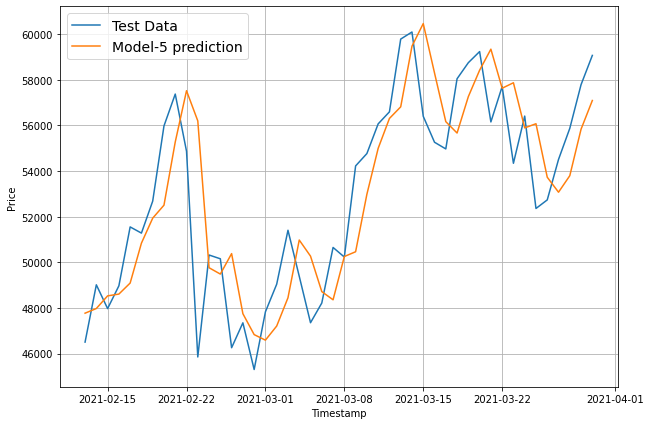

In [119]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_5_preds, format="-", start=offset, label="Model-5 prediction")

## Make a multivariate time-series

In an open system, there are many features that affect the bitcoin price.
In bitcoin halving event, as halving happens, the amount of block reward (the amount of bitcoin we get as a reward after mining) gets decreased.

In [106]:
# Lets make a multivariate time series
btc_df.tail()

,Price
Timestamp,
2021-03-26,52734.30
2021-03-27,54508.16
2021-03-28,55871.93
2021-03-29,57788.15
2021-03-30,59069.29


In [107]:
# Adding the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009- this block reward isn't in our dataset
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [108]:
btc_df.index[0] < block_reward_3_datetime

True

In [109]:

# block_reward_2_boundary = block_reward_3_datetime - btc_df.index[0]
# block_reward_3_boundary = block_reward_4_datetime - btc_df.index[0]

# block_reward_2_boundary.days, block_reward_3_boundary.days

In [110]:
# len(btc_df), btc_block_df.iloc[block_reward_3_boundary.days:]

In [111]:
# btc_block_df = btc_df.copy()
# btc_block_df["Block_reward"] = None

# btc_block_df.iloc[:block_reward_2_boundary.days, -1] = block_reward_2 # -1 means get the last columns
# btc_block_df.iloc[block_reward_2_boundary.days:block_reward_3_boundary.days,-1] = block_reward_3
# btc_block_df.iloc[block_reward_3_boundary.days:, -1] = block_reward_4
# btc_block_df.head(), btc_block_df.tail()


In [112]:
# Adding the specific block reward value
reward = []
for i in range(len(btc_df)):
  timestamp = btc_df.index[i]
  if (timestamp <= block_reward_3_datetime and timestamp >= block_reward_2_datetime): reward.append(block_reward_2)
  elif (timestamp <= block_reward_4_datetime and timestamp >= block_reward_3_datetime): reward.append(block_reward_3)
  else: reward.append(block_reward_4) 


In [113]:
# len(reward), len(btc_df)
# btc_df["reward"] = reward
btc_blk_df = btc_df.copy()
btc_blk_df["Block_reward"] = reward
btc_blk_df

,Price,Block_reward
Timestamp,,
2014-01-01,754.90,25.00
2014-01-02,784.19,25.00
2014-01-03,809.40,25.00
2014-01-04,828.79,25.00
2014-01-05,905.00,25.00
...,...,...
2021-03-26,52734.30,6.25
2021-03-27,54508.16,6.25
2021-03-28,55871.93,6.25


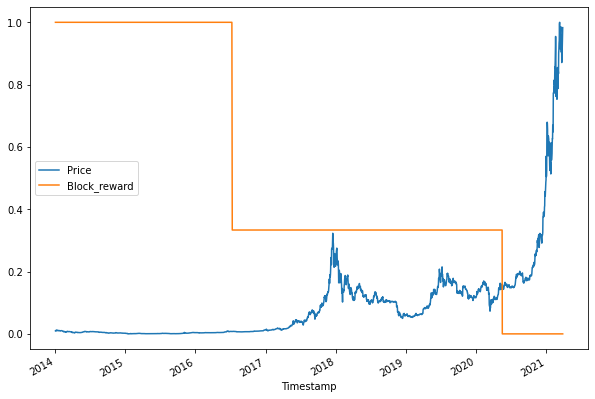

In [114]:
# Convert the y-scaling of each features to a range of [0,1] to include in the same plot
from sklearn.preprocessing import minmax_scale
scaled_btc_blk_df = pd.DataFrame(minmax_scale(btc_blk_df[["Price", "Block_reward"]]), 
                                 columns = btc_blk_df.columns,
                                 index=btc_blk_df.index
                                 )

scaled_btc_blk_df.plot(figsize = (10,7));

## Making a windowed dataset with pandas
Above functions for making a windowed dataset doesn't work for multivariate data.


In [ ]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [ ]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,block_reward] -> [7]
  [1,2,3,4,5,6,7,block_reward] -> [8]
"""
btc_windowed_df = btc_blk_df.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_blk_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,Price,Block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Timestamp,,,,,,,,,
2014-01-01,754.90,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,784.19,25.0,754.90,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,809.40,25.0,784.19,754.90,NaN,NaN,NaN,NaN,NaN
2014-01-04,828.79,25.0,809.40,784.19,754.90,NaN,NaN,NaN,NaN
2014-01-05,905.00,25.0,828.79,809.40,784.19,754.90,NaN,NaN,NaN
2014-01-06,919.24,25.0,905.00,828.79,809.40,784.19,754.90,NaN,NaN
2014-01-07,785.00,25.0,919.24,905.00,828.79,809.40,784.19,754.90,NaN
2014-01-09,824.76,25.0,785.00,919.24,905.00,828.79,809.40,784.19,754.90
2014-01-10,852.61,25.0,824.76,785.00,919.24,905.00,828.79,809.40,784.19


In [ ]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
x = btc_windowed_df.dropna().drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df.dropna()["Price"].astype(np.float32) # labels
x.head(), y.head()

(            Block_reward     Price+1     Price+2     Price+3     Price+4  \
 Timestamp                                                                  
 2014-01-09          25.0  785.000000  919.239990  905.000000  828.789978   
 2014-01-10          25.0  824.760010  785.000000  919.239990  905.000000   
 2014-01-11          25.0  852.609985  824.760010  785.000000  919.239990   
 2014-01-12          25.0  896.590027  852.609985  824.760010  785.000000   
 2014-01-13          25.0  844.049988  896.590027  852.609985  824.760010   
 
                Price+5     Price+6     Price+7  
 Timestamp                                       
 2014-01-09  809.400024  784.190002  754.900024  
 2014-01-10  828.789978  809.400024  784.190002  
 2014-01-11  905.000000  828.789978  809.400024  
 2014-01-12  919.239990  905.000000  828.789978  
 2014-01-13  785.000000  919.239990  905.000000  , Timestamp
 2014-01-09    824.760010
 2014-01-10    852.609985
 2014-01-11    896.590027
 2014-01-12    844.0

In [ ]:
# Make train and test sets using indexing
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]


In [ ]:
# Make model6
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # upgrading the model performance
  layers.Dense(HORIZON)
], name='model_6_multivariate')

model_6.compile(
    loss = "mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = "mae"
)

model_6.fit(x=x_train,
            y=y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)]
            )



Epoch 1/100
 1/14 [=>............................] - ETA: 6s - loss: 4722.0156 - mae: 4722.0156INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 67ms/step - loss: 1664.6705 - mae: 1664.6705 - val_loss: 2853.5791 - val_mae: 2853.5791
Epoch 2/100
 1/14 [=>............................] - ETA: 0s - loss: 663.1874 - mae: 663.1874INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 380.9536 - mae: 380.9536 - val_loss: 903.4773 - val_mae: 903.4773
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 260.0276 - mae: 260.0276 - val_loss: 932.3580 - val_mae: 932.3580
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 208.2210 - mae: 208.2210INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 208.2210 - mae: 208.2210 - val_loss: 806.9494 - val_mae: 806.9494
Epoch 5/100
 1/14 [=>............................] - ETA: 0s - loss: 169.9901 - mae: 169.9901INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 188.2608 - mae: 188.2608 - val_loss: 742.2965 - val_mae: 742.2965
Epoch 6/100
 1/14 [=>............................] - ETA: 0s - loss: 179.3373 - mae: 179.3373INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 169.8540 - mae: 169.8540 - val_loss: 710.6755 - val_mae: 710.6755
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 159.4001 - mae: 159.4001 - val_loss: 714.6719 - val_mae: 714.6719
Epoch 8/100
 1/14 [=>............................] - ETA: 0s - loss: 172.4552 - mae: 172.4552INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 151.0546 - mae: 151.0546 - val_loss: 701.3104 - val_mae: 701.3104
Epoch 9/100
14/14 [==============================] - 0s 6ms/step - loss: 147.5343 - mae: 147.5343 - val_loss: 746.7619 - val_mae: 746.7619
Epoch 10/100
11/14 [======================>.......] - ETA: 0s - loss: 150.2635 - mae: 150.2635INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 59ms/step - loss: 148.4816 - mae: 148.4816 - val_loss: 650.9011 - val_mae: 650.9011
Epoch 11/100
14/14 [==============================] - ETA: 0s - loss: 141.8549 - mae: 141.8549INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 59ms/step - loss: 141.8549 - mae: 141.8549 - val_loss: 646.2353 - val_mae: 646.2353
Epoch 12/100
14/14 [==============================] - 0s 7ms/step - loss: 144.4275 - mae: 144.4275 - val_loss: 703.6052 - val_mae: 703.6052
Epoch 13/100
 1/14 [=>............................] - ETA: 0s - loss: 156.1834 - mae: 156.1834INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 56ms/step - loss: 150.5231 - mae: 150.5231 - val_loss: 622.1036 - val_mae: 622.1036
Epoch 14/100
14/14 [==============================] - ETA: 0s - loss: 141.8803 - mae: 141.8803INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 141.8803 - mae: 141.8803 - val_loss: 620.8207 - val_mae: 620.8207
Epoch 15/100
14/14 [==============================] - 0s 7ms/step - loss: 141.8348 - mae: 141.8348 - val_loss: 659.0938 - val_mae: 659.0938
Epoch 16/100
14/14 [==============================] - 0s 6ms/step - loss: 139.7112 - mae: 139.7112 - val_loss: 632.5565 - val_mae: 632.5565
Epoch 17/100
14/14 [==============================] - ETA: 0s - loss: 141.8528 - mae: 141.8528INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 141.8528 - mae: 141.8528 - val_loss: 619.2538 - val_mae: 619.2538
Epoch 18/100
 1/14 [=>............................] - ETA: 0s - loss: 142.3178 - mae: 142.3178INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 55ms/step - loss: 138.5913 - mae: 138.5913 - val_loss: 613.0410 - val_mae: 613.0410
Epoch 19/100
14/14 [==============================] - 0s 7ms/step - loss: 150.2802 - mae: 150.2802 - val_loss: 664.3789 - val_mae: 664.3789
Epoch 20/100
14/14 [==============================] - 0s 6ms/step - loss: 143.5255 - mae: 143.5255 - val_loss: 628.1452 - val_mae: 628.1452
Epoch 21/100
 1/14 [=>............................] - ETA: 0s - loss: 132.4749 - mae: 132.4749INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 137.5202 - mae: 137.5202 - val_loss: 600.9904 - val_mae: 600.9904
Epoch 22/100
14/14 [==============================] - 0s 7ms/step - loss: 138.8326 - mae: 138.8326 - val_loss: 607.5034 - val_mae: 607.5034
Epoch 23/100
14/14 [==============================] - 0s 6ms/step - loss: 146.2579 - mae: 146.2579 - val_loss: 606.4139 - val_mae: 606.4139
Epoch 24/100
14/14 [==============================] - 0s 6ms/step - loss: 150.5128 - mae: 150.5128 - val_loss: 670.9826 - val_mae: 670.9826
Epoch 25/100
14/14 [==============================] - 0s 7ms/step - loss: 135.5896 - mae: 135.5896 - val_loss: 601.6369 - val_mae: 601.6369
Epoch 26/100
14/14 [==============================] - 0s 7ms/step - loss: 135.2020 - mae: 135.2020 - val_loss: 608.8314 - val_mae: 608.8314
Epoch 27/100
 1/14 [=>............................] - ETA: 0s - loss: 144.2347 - mae: 144.2347INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 89ms/step - loss: 135.7666 - mae: 135.7666 - val_loss: 592.3569 - val_mae: 592.3569
Epoch 28/100
14/14 [==============================] - 0s 7ms/step - loss: 137.0217 - mae: 137.0217 - val_loss: 678.4568 - val_mae: 678.4568
Epoch 29/100
14/14 [==============================] - 0s 7ms/step - loss: 147.3989 - mae: 147.3989 - val_loss: 713.8589 - val_mae: 713.8589
Epoch 30/100
 1/14 [=>............................] - ETA: 0s - loss: 141.8109 - mae: 141.8109INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 56ms/step - loss: 141.2391 - mae: 141.2391 - val_loss: 590.8990 - val_mae: 590.8990
Epoch 31/100
14/14 [==============================] - 0s 6ms/step - loss: 140.4270 - mae: 140.4270 - val_loss: 646.3834 - val_mae: 646.3834
Epoch 32/100
14/14 [==============================] - 0s 6ms/step - loss: 139.2978 - mae: 139.2978 - val_loss: 629.9029 - val_mae: 629.9029
Epoch 33/100
14/14 [==============================] - 0s 7ms/step - loss: 139.6836 - mae: 139.6836 - val_loss: 659.2035 - val_mae: 659.2035
Epoch 34/100
14/14 [==============================] - 0s 6ms/step - loss: 141.9372 - mae: 141.9372 - val_loss: 594.3145 - val_mae: 594.3145
Epoch 35/100
 1/14 [=>............................] - ETA: 0s - loss: 122.4991 - mae: 122.4991INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 56ms/step - loss: 132.4200 - mae: 132.4200 - val_loss: 588.4839 - val_mae: 588.4839
Epoch 36/100
14/14 [==============================] - 0s 6ms/step - loss: 132.3066 - mae: 132.3066 - val_loss: 625.8398 - val_mae: 625.8398
Epoch 37/100
11/14 [======================>.......] - ETA: 0s - loss: 129.6709 - mae: 129.6709INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 59ms/step - loss: 132.9449 - mae: 132.9449 - val_loss: 586.7679 - val_mae: 586.7679
Epoch 38/100
14/14 [==============================] - 0s 7ms/step - loss: 131.3973 - mae: 131.3973 - val_loss: 594.2787 - val_mae: 594.2787
Epoch 39/100
14/14 [==============================] - ETA: 0s - loss: 132.3660 - mae: 132.3660INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 132.3660 - mae: 132.3660 - val_loss: 583.9753 - val_mae: 583.9753
Epoch 40/100
14/14 [==============================] - 0s 6ms/step - loss: 130.4908 - mae: 130.4908 - val_loss: 586.1899 - val_mae: 586.1899
Epoch 41/100
14/14 [==============================] - 0s 6ms/step - loss: 130.4931 - mae: 130.4931 - val_loss: 597.9796 - val_mae: 597.9796
Epoch 42/100
14/14 [==============================] - 0s 7ms/step - loss: 139.0201 - mae: 139.0201 - val_loss: 792.6824 - val_mae: 792.6824
Epoch 43/100
14/14 [==============================] - 0s 8ms/step - loss: 141.8969 - mae: 141.8969 - val_loss: 594.8047 - val_mae: 594.8047
Epoch 44/100
14/14 [==============================] - 0s 7ms/step - loss: 136.1419 - mae: 136.1419 - val_loss: 660.4113 - val_mae: 660.4113
Epoch 45/100
 1/14 [=>............................] - ETA: 0s - loss: 128.1483 - mae: 128.1483INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 145.3924 - mae: 145.3924 - val_loss: 579.9916 - val_mae: 579.9916
Epoch 46/100
14/14 [==============================] - 0s 6ms/step - loss: 138.8629 - mae: 138.8629 - val_loss: 587.2500 - val_mae: 587.2500
Epoch 47/100
14/14 [==============================] - 0s 7ms/step - loss: 164.2287 - mae: 164.2287 - val_loss: 844.5879 - val_mae: 844.5879
Epoch 48/100
 1/14 [=>............................] - ETA: 0s - loss: 240.5826 - mae: 240.5826INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 56ms/step - loss: 174.0870 - mae: 174.0870 - val_loss: 574.8292 - val_mae: 574.8292
Epoch 49/100
14/14 [==============================] - 0s 6ms/step - loss: 146.5021 - mae: 146.5021 - val_loss: 582.3984 - val_mae: 582.3984
Epoch 50/100
14/14 [==============================] - 0s 7ms/step - loss: 136.6007 - mae: 136.6007 - val_loss: 592.7776 - val_mae: 592.7776
Epoch 51/100
14/14 [==============================] - 0s 8ms/step - loss: 133.1944 - mae: 133.1944 - val_loss: 613.4579 - val_mae: 613.4579
Epoch 52/100
14/14 [==============================] - 0s 6ms/step - loss: 133.8255 - mae: 133.8255 - val_loss: 576.9481 - val_mae: 576.9481
Epoch 53/100
14/14 [==============================] - 0s 7ms/step - loss: 132.0508 - mae: 132.0508 - val_loss: 718.9019 - val_mae: 718.9019
Epoch 54/100
14/14 [==============================] - 0s 7ms/step - loss: 133.3262 - mae: 133.3262 - val_loss: 601.8124 - val_mae: 601.8124
Epoch 55/100
14/14 [============

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 55ms/step - loss: 134.6321 - mae: 134.6321 - val_loss: 574.5074 - val_mae: 574.5074
Epoch 57/100
14/14 [==============================] - 0s 6ms/step - loss: 129.9545 - mae: 129.9545 - val_loss: 609.1415 - val_mae: 609.1415
Epoch 58/100
14/14 [==============================] - 0s 6ms/step - loss: 129.3819 - mae: 129.3819 - val_loss: 620.6880 - val_mae: 620.6880
Epoch 59/100
14/14 [==============================] - 0s 6ms/step - loss: 129.4659 - mae: 129.4659 - val_loss: 585.4573 - val_mae: 585.4573
Epoch 60/100
 1/14 [=>............................] - ETA: 0s - loss: 104.7673 - mae: 104.7673INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 56ms/step - loss: 134.8370 - mae: 134.8370 - val_loss: 573.0924 - val_mae: 573.0924
Epoch 61/100
14/14 [==============================] - 0s 6ms/step - loss: 130.0036 - mae: 130.0036 - val_loss: 576.0202 - val_mae: 576.0202
Epoch 62/100
14/14 [==============================] - 0s 9ms/step - loss: 134.3845 - mae: 134.3845 - val_loss: 654.3719 - val_mae: 654.3719
Epoch 63/100
14/14 [==============================] - 0s 6ms/step - loss: 134.1791 - mae: 134.1791 - val_loss: 600.5419 - val_mae: 600.5419
Epoch 64/100
14/14 [==============================] - 0s 7ms/step - loss: 133.2120 - mae: 133.2120 - val_loss: 576.6777 - val_mae: 576.6777
Epoch 65/100
14/14 [==============================] - 0s 6ms/step - loss: 129.1147 - mae: 129.1147 - val_loss: 704.2703 - val_mae: 704.2703
Epoch 66/100
 1/14 [=>............................] - ETA: 0s - loss: 177.4953 - mae: 177.4953INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 130.9791 - mae: 130.9791 - val_loss: 571.6816 - val_mae: 571.6816
Epoch 67/100
14/14 [==============================] - 0s 7ms/step - loss: 128.1152 - mae: 128.1152 - val_loss: 581.8458 - val_mae: 581.8458
Epoch 68/100
14/14 [==============================] - 0s 6ms/step - loss: 134.1891 - mae: 134.1891 - val_loss: 585.6915 - val_mae: 585.6915
Epoch 69/100
14/14 [==============================] - 0s 7ms/step - loss: 136.8459 - mae: 136.8459 - val_loss: 723.5985 - val_mae: 723.5985
Epoch 70/100
14/14 [==============================] - 0s 6ms/step - loss: 133.2160 - mae: 133.2160 - val_loss: 600.2916 - val_mae: 600.2916
Epoch 71/100
 1/14 [=>............................] - ETA: 0s - loss: 128.9763 - mae: 128.9763INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 57ms/step - loss: 136.1790 - mae: 136.1790 - val_loss: 569.4994 - val_mae: 569.4994
Epoch 72/100
14/14 [==============================] - 0s 6ms/step - loss: 139.7676 - mae: 139.7676 - val_loss: 675.4498 - val_mae: 675.4498
Epoch 73/100
14/14 [==============================] - 0s 6ms/step - loss: 141.4134 - mae: 141.4134 - val_loss: 640.1417 - val_mae: 640.1417
Epoch 74/100
 1/14 [=>............................] - ETA: 0s - loss: 139.0228 - mae: 139.0228INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 131.6112 - mae: 131.6112 - val_loss: 568.7466 - val_mae: 568.7466
Epoch 75/100
14/14 [==============================] - 0s 7ms/step - loss: 131.0955 - mae: 131.0955 - val_loss: 656.8320 - val_mae: 656.8320
Epoch 76/100
14/14 [==============================] - 0s 7ms/step - loss: 130.3638 - mae: 130.3638 - val_loss: 572.6025 - val_mae: 572.6025
Epoch 77/100
14/14 [==============================] - 0s 7ms/step - loss: 131.5488 - mae: 131.5488 - val_loss: 615.9517 - val_mae: 615.9517
Epoch 78/100
14/14 [==============================] - 0s 7ms/step - loss: 144.8930 - mae: 144.8930 - val_loss: 620.6269 - val_mae: 620.6269
Epoch 79/100
14/14 [==============================] - 0s 7ms/step - loss: 146.5535 - mae: 146.5535 - val_loss: 596.0645 - val_mae: 596.0645
Epoch 80/100
14/14 [==============================] - 0s 8ms/step - loss: 138.1514 - mae: 138.1514 - val_loss: 633.9855 - val_mae: 633.9855
Epoch 81/100
14/14 [============

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 58ms/step - loss: 126.1360 - mae: 126.1360 - val_loss: 567.5917 - val_mae: 567.5917
Epoch 90/100
14/14 [==============================] - 0s 7ms/step - loss: 128.5615 - mae: 128.5615 - val_loss: 625.6862 - val_mae: 625.6862
Epoch 91/100
14/14 [==============================] - 0s 7ms/step - loss: 132.0071 - mae: 132.0071 - val_loss: 666.4282 - val_mae: 666.4282
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 133.1182 - mae: 133.1182 - val_loss: 567.9746 - val_mae: 567.9746
Epoch 93/100
14/14 [==============================] - 0s 7ms/step - loss: 131.1450 - mae: 131.1450 - val_loss: 641.3860 - val_mae: 641.3860
Epoch 94/100
14/14 [==============================] - 0s 8ms/step - loss: 137.4610 - mae: 137.4610 - val_loss: 600.2836 - val_mae: 600.2836
Epoch 95/100
14/14 [==============================] - 0s 6ms/step - loss: 129.2387 - mae: 129.2387 - val_loss: 589.6412 - val_mae: 589.6412
Epoch 96/100
14/14 [============

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 59ms/step - loss: 126.8940 - mae: 126.8940 - val_loss: 566.6452 - val_mae: 566.6452


In [ ]:
model_6.evaluate(x_test, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 566.6452 - mae: 566.6452


[566.6452026367188, 566.6452026367188]

In [ ]:
model_6 = tf.keras.models.load_model("models/model_6_multivariate")
model_6.evaluate(x_test, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 566.6452 - mae: 566.6452


[566.6452026367188, 566.6452026367188]

In [ ]:
# Make predictions

model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 566.6452,
 'mape': 2.8200758,
 'mase': 0.99867654,
 'mse': 1348993.0,
 'rmse': 1161.4615}

In [120]:
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi.csv

--2022-05-10 01:53:44--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150707 (147K) [text/plain]
Saving to: ‘daily_multi.csv’

daily_multi.csv     100%[===================>] 147.17K  --.-KB/s    in 0.003s  

2022-05-10 01:53:44 (57.2 MB/s) - ‘daily_multi.csv’ saved [150707/150707]



In [121]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_multi.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'].dt.date)
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(            BTC_Volume  CURRENCY_Volume  Daily_Open   Price  Daily_High  \
 Timestamp                                                                 
 2014-01-01   54.537393      41030.73303      732.00  754.90      757.99   
 2014-01-02  473.353037     370482.78250      732.00  784.19      798.70   
 2014-01-03   22.080903      17831.05554      784.19  809.40      818.99   
 2014-01-04  513.010428     425028.52890      784.19  828.79      830.00   
 2014-01-05    4.497195       4069.64165      828.79  905.00      948.00   
 
             Daily_Low  
 Timestamp              
 2014-01-01     729.01  
 2014-01-02     729.01  
 2014-01-03     767.62  
 2014-01-04     767.62  
 2014-01-05     826.07  ,
             BTC_Volume  CURRENCY_Volume  Daily_Open     Price  Daily_High  \
 Timestamp                                                                   
 2021-03-26    1.432076     7.886414e+04    52704.74  52734.30    55114.86   
 2021-03-27   35.303980     1.975370e+06    54511.41  54

In [123]:
#  Windows the dataset directly from the pandas dataframe
"""
  [0,1,2,3,4,5,6,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [7]
  [1,2,3,4,5,6,7,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low] -> [8]
"""
btc_windowed_df = btc_df.copy() # copy is needed to avoid pandas warning

# Adds windowed columns
for i in range(WINDOW_SIZE):
  btc_windowed_df[f"Price+{i+1}"] = btc_blk_df["Price"].shift(periods=i+1)
btc_windowed_df.head(10)

,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Timestamp,,,,,,,,,,,,,
2014-01-01,54.537393,4.103073e+04,732.00,754.90,757.99,729.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,473.353037,3.704828e+05,732.00,784.19,798.70,729.01,754.90,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,22.080903,1.783106e+04,784.19,809.40,818.99,767.62,784.19,754.90,NaN,NaN,NaN,NaN,NaN
2014-01-04,513.010428,4.250285e+05,784.19,828.79,830.00,767.62,809.40,784.19,754.90,NaN,NaN,NaN,NaN
2014-01-05,4.497195,4.069642e+03,828.79,905.00,948.00,826.07,828.79,809.40,784.19,754.90,NaN,NaN,NaN
2014-01-06,241.609301,2.206829e+05,905.00,919.24,995.00,876.00,905.00,828.79,809.40,784.19,754.90,NaN,NaN
2014-01-07,1886.630033,1.515490e+06,915.80,785.00,943.00,785.00,919.24,905.00,828.79,809.40,784.19,754.90,NaN
2014-01-09,667.490877,5.533121e+05,823.94,824.76,848.00,779.78,785.00,919.24,905.00,828.79,809.40,784.19,754.90
2014-01-10,7.394014,6.315893e+03,825.50,852.61,861.40,799.41,824.76,785.00,919.24,905.00,828.79,809.40,784.19


In [124]:
# Removing the rows with the missing values
# Create X (windows) and Y (horizons) features
x = btc_windowed_df.dropna().drop("Price", axis=1).astype(np.float32) # windows
y = btc_windowed_df.dropna()["Price"].astype(np.float32) # labels
x.head(), y.head()

(            BTC_Volume  CURRENCY_Volume  Daily_Open  Daily_High   Daily_Low  \
 Timestamp                                                                     
 2014-01-09  667.490906    553312.125000  823.940002  848.000000  779.780029   
 2014-01-10    7.394014      6315.893066  825.500000  861.400024  799.409973   
 2014-01-11  245.935730    219613.734375  851.630005  909.960022  849.510010   
 2014-01-12  166.956573    141199.734375  895.000000  905.000000  826.460022   
 2014-01-13   56.784340     46610.644531  844.039978  844.049988  783.109985   
 
                Price+1     Price+2     Price+3     Price+4     Price+5  \
 Timestamp                                                                
 2014-01-09  785.000000  919.239990  905.000000  828.789978  809.400024   
 2014-01-10  824.760010  785.000000  919.239990  905.000000  828.789978   
 2014-01-11  852.609985  824.760010  785.000000  919.239990  905.000000   
 2014-01-12  896.590027  852.609985  824.760010  785.000000  91

In [125]:
# Make train and test sets using indexing
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]


In [126]:
# Make model6
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # upgrading the model performance
  layers.Dense(HORIZON)
], name='model_6_multivariate')

model_6.compile(
    loss = "mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = "mae"
)

model_6.fit(x=x_train,
            y=y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)]
            )



Epoch 1/100
 1/14 [=>............................] - ETA: 4s - loss: 26196.4141 - mae: 26196.4141INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 46ms/step - loss: 7547.0161 - mae: 7547.0161 - val_loss: 13058.1699 - val_mae: 13058.1699
Epoch 2/100
 1/14 [=>............................] - ETA: 0s - loss: 4295.6519 - mae: 4295.6519INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 39ms/step - loss: 4620.4087 - mae: 4620.4087 - val_loss: 2634.2102 - val_mae: 2634.2102
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 2234.4558 - mae: 2234.4558 - val_loss: 16253.8027 - val_mae: 16253.8027
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 4808.3657 - mae: 4808.3657 - val_loss: 9098.9150 - val_mae: 9098.9150
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 2223.5181 - mae: 2223.5181 - val_loss: 18790.9531 - val_mae: 18790.9531
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 7111.0898 - mae: 7111.0898 - val_loss: 15628.1279 - val_mae: 15628.1279
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 2740.1687 - mae: 2740.1687 - val_loss: 3779.2659 - val_mae: 3779.2659
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 3898.2725 - mae: 3898.2725 - val_loss: 41112.6641 - val_mae: 41112.6641
Ep

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 61ms/step - loss: 3032.9109 - mae: 3032.9109 - val_loss: 986.2102 - val_mae: 986.2102
Epoch 11/100
14/14 [==============================] - 0s 5ms/step - loss: 2515.3433 - mae: 2515.3433 - val_loss: 29215.7168 - val_mae: 29215.7168
Epoch 12/100
14/14 [==============================] - 0s 5ms/step - loss: 5463.5972 - mae: 5463.5972 - val_loss: 13615.3408 - val_mae: 13615.3408
Epoch 13/100
14/14 [==============================] - 0s 5ms/step - loss: 2400.0352 - mae: 2400.0352 - val_loss: 5196.2871 - val_mae: 5196.2871
Epoch 14/100
14/14 [==============================] - 0s 5ms/step - loss: 2800.6970 - mae: 2800.6970 - val_loss: 28706.9551 - val_mae: 28706.9551
Epoch 15/100
14/14 [==============================] - 0s 4ms/step - loss: 6066.4268 - mae: 6066.4268 - val_loss: 21451.3281 - val_mae: 21451.3281
Epoch 16/100
14/14 [==============================] - 0s 5ms/step - loss: 5547.0928 - mae: 5547.0928 - val_loss: 5921.5220 - val_mae: 5921.522

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 40ms/step - loss: 792.9655 - mae: 792.9655 - val_loss: 864.1033 - val_mae: 864.1033
Epoch 57/100
14/14 [==============================] - 0s 5ms/step - loss: 3559.4133 - mae: 3559.4133 - val_loss: 5234.0449 - val_mae: 5234.0449
Epoch 58/100
14/14 [==============================] - 0s 4ms/step - loss: 3644.2668 - mae: 3644.2666 - val_loss: 26092.4219 - val_mae: 26092.4219
Epoch 59/100
14/14 [==============================] - 0s 6ms/step - loss: 4944.2554 - mae: 4944.2554 - val_loss: 27901.3984 - val_mae: 27901.3984
Epoch 60/100
14/14 [==============================] - 0s 4ms/step - loss: 6410.7358 - mae: 6410.7358 - val_loss: 11685.5654 - val_mae: 11685.5654
Epoch 61/100
14/14 [==============================] - 0s 4ms/step - loss: 2552.3811 - mae: 2552.3811 - val_loss: 3453.3352 - val_mae: 3453.3352
Epoch 62/100
14/14 [==============================] - 0s 6ms/step - loss: 1949.4933 - mae: 1949.4933 - val_loss: 9861.2168 - val_mae: 9861.2168
Ep

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 38ms/step - loss: 2773.2891 - mae: 2773.2891 - val_loss: 656.0136 - val_mae: 656.0136
Epoch 92/100
14/14 [==============================] - 0s 5ms/step - loss: 687.7838 - mae: 687.7838 - val_loss: 1579.3445 - val_mae: 1579.3445
Epoch 93/100
14/14 [==============================] - 0s 5ms/step - loss: 1686.4991 - mae: 1686.4991 - val_loss: 8516.2822 - val_mae: 8516.2822
Epoch 94/100
14/14 [==============================] - 0s 4ms/step - loss: 3978.5408 - mae: 3978.5408 - val_loss: 16415.7109 - val_mae: 16415.7109
Epoch 95/100
14/14 [==============================] - 0s 5ms/step - loss: 3549.9055 - mae: 3549.9055 - val_loss: 10812.2021 - val_mae: 10812.2021
Epoch 96/100
14/14 [==============================] - 0s 4ms/step - loss: 1623.5433 - mae: 1623.5433 - val_loss: 5622.2212 - val_mae: 5622.2212
Epoch 97/100
14/14 [==============================] - 0s 4ms/step - loss: 1356.1743 - mae: 1356.1743 - val_loss: 1680.2358 - val_mae: 1680.2358
Epoc

INFO:tensorflow:Assets written to: models/model_6_multivariate/assets


14/14 [==============================] - 1s 39ms/step - loss: 1581.8386 - mae: 1581.8386 - val_loss: 650.6743 - val_mae: 650.6743
Epoch 100/100
14/14 [==============================] - 0s 6ms/step - loss: 1525.2286 - mae: 1525.2286 - val_loss: 13327.6611 - val_mae: 13327.6611


In [127]:
model_6 = tf.keras.models.load_model("models/model_6_multivariate")
model_6.evaluate(x_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 650.6743 - mae: 650.6743


[650.67431640625, 650.67431640625]

In [128]:
# Make predictions

model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 650.67426,
 'mape': 3.389785,
 'mase': 0.99867654,
 'mse': 1315675.0,
 'rmse': 1147.0287}

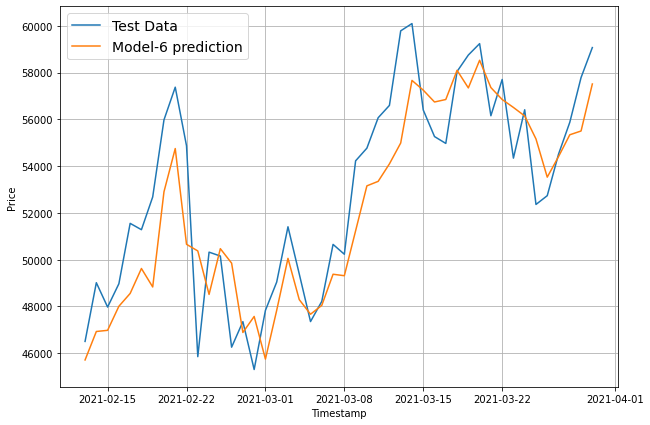

In [129]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_6_preds, format="-", start=offset, label="Model-6 prediction")

In [130]:
model_6.summary()

Model: "model_6_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1664      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 18,305
Trainable params: 18,305
Non-trainable params: 0
_________________________________________________________________


## Creating an ensemble model (which means stacking different models)
Longer training and longer prediction time --> better accuracy.


An ensemble combines many different models to predict a common goal.

In [ ]:
HORIZON =1
WINDOW_SIZE = 7

In [ ]:
x_train

,Block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Timestamp,,,,,,,,
2014-01-09,25.0,785.000000,919.239990,905.000000,828.789978,809.400024,784.190002,754.900024
2014-01-10,25.0,824.760010,785.000000,919.239990,905.000000,828.789978,809.400024,784.190002
2014-01-11,25.0,852.609985,824.760010,785.000000,919.239990,905.000000,828.789978,809.400024
2014-01-12,25.0,896.590027,852.609985,824.760010,785.000000,919.239990,905.000000,828.789978
2014-01-13,25.0,844.049988,896.590027,852.609985,824.760010,785.000000,919.239990,905.000000
...,...,...,...,...,...,...,...,...
2019-12-30,12.5,7326.000000,7284.589844,7133.649902,7181.729980,7208.689941,7366.009766,7548.990234
2019-12-31,12.5,7298.620117,7326.000000,7284.589844,7133.649902,7181.729980,7208.689941,7366.009766
2020-01-01,12.5,7222.109863,7298.620117,7326.000000,7284.589844,7133.649902,7181.729980,7208.689941


In [ ]:
len(x_train), len(y_train), len(x_test), len(y_test)
                                             
# Convert the train and test datasets to tf.data.Dataset to ensure fast running time
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [ ]:
# Constructs and fits and ensembles models (using different loss functions)
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
  For example: if num_iter==10, a list of 30 trained models will be returned:
  10*len(loss_fns)
  """
  # Make empty list for trained ensemble models
  ensemble_models=[]

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # initializing the normal distribution instead of the default uniform
        # normal distribution is used to initialize for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON) # output layer
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
            epochs=num_epochs,
            verbose=0,
            validation_data=test_data,
            # First callback: If the val_loss doesn't change for 200 epochs, then do not 
            # wait. Load the best model and exit
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)]
            )
      ensemble_models.append(model)
  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=100)

Optimizing model by reducing: mae for 100 epochs, model number: 0
Optimizing model by reducing: mse for 100 epochs, model number: 0
Optimizing model by reducing: mape for 100 epochs, model number: 0
Optimizing model by reducing: mae for 100 epochs, model number: 1
Optimizing model by reducing: mse for 100 epochs, model number: 1
Optimizing model by reducing: mape for 100 epochs, model number: 1
Optimizing model by reducing: mae for 100 epochs, model number: 2
Optimizing model by reducing: mse for 100 epochs, model number: 2
Optimizing model by reducing: mape for 100 epochs, model number: 2
Optimizing model by reducing: mae for 100 epochs, model number: 3
Optimizing model by reducing: mse for 100 epochs, model number: 3
Optimizing model by reducing: mape for 100 epochs, model number: 3
Optimizing model by reducing: mae for 100 epochs, model number: 4
Optimizing model by reducing: mse for 100 epochs, model number: 4
Optimizing model by reducing: mape for 100 epochs, model number: 4
CPU t

In [ ]:
len(ensemble_models)
# ensemble_models

15

### Make predictions with our ensemble model

In [ ]:
# Create a functions which uses a list of trained models to make and return a list of predictions
def make_ensemble_predictions(ensemble_models, data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_predictions(ensemble_models=ensemble_models, data=test_dataset)
# Trade-off in this process is that we are repeatedly calling tensorflow function in a for-loop
# so maybe there is a decent slowdown

CPU times: user 833 ms, sys: 38 ms, total: 871 ms
Wall time: 826 ms


In [ ]:
"""
  All these 15 loss functions are different because:
  (i) They use different loss-functions
  (ii) They are randomly initialized    
"""
ensemble_preds

<tf.Tensor: shape=(15, 446), dtype=float32, numpy=
array([[ 7260.148 ,  7298.5693,  7388.3716, ..., 53908.094 , 55533.188 ,
        56655.207 ],
       [ 7221.5337,  7274.737 ,  7349.6216, ..., 53910.406 , 55216.06  ,
        56302.652 ],
       [ 7057.406 ,  7115.173 ,  7189.946 , ..., 53074.65  , 53673.004 ,
        56465.004 ],
       ...,
       [ 7282.0205,  7327.464 ,  7385.246 , ..., 55309.77  , 54673.02  ,
        58222.562 ],
       [ 7187.251 ,  7319.388 ,  7337.8184, ..., 54291.414 , 55455.848 ,
        56857.953 ],
       [ 7430.3022,  7469.784 ,  7588.4194, ..., 56285.64  , 55785.254 ,
        59358.805 ]], dtype=float32)>

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
ensemble_results

{'mae': 668.74744,
 'mape': 3.361051,
 'mase': 0.99867654,
 'mse': 1651769.5,
 'rmse': 1280.1855}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis = 0) # take mean on the rows
# In this all models make their predictions and we are taking the mean of the predictions
# made by each model
ensemble_mean.shape

TensorShape([446])

In [ ]:
# Since tensorflow doesn't have tf.reduce_median to compute median directly
# we are going to use numpy
ensemble_median = np.median(ensemble_preds, axis=0)
len(ensemble_median)

446

In [ ]:
evaluate_preds(y_true=y_test, y_pred=ensemble_mean)

{'mae': 593.55084,
 'mape': 2.902447,
 'mase': 0.99867654,
 'mse': 1376315.8,
 'rmse': 1173.1648}

In [ ]:
evaluate_preds(y_true=y_test, y_pred=ensemble_median)

{'mae': 602.22534,
 'mape': 2.9396405,
 'mase': 0.99867654,
 'mse': 1429014.5,
 'rmse': 1195.414}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble
Till now, we are making a point prediction, but we can make a range prediciton too using the ensemble models.

Because the point predictions are never exactly correct. So, giving a range is better and give more information on how our model is thinking. But, when we have a range, there comes a problem on whether we should choose the upper bound or choose the lower bound.

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this from our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is normal and this is also the reason that when defining the ensemble model, the kernel initializer is used as the kernel)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).

# Future prediction Model

## Model 9: Train a model on the full historical data to make a prediction into the future
So far all of our models have predicted on the test dataset. However this is only pseudofuture. Let's now build a model which is capable of predicting into the future.

In [132]:
btc_windowed_df.head()

,BTC_Volume,CURRENCY_Volume,Daily_Open,Price,Daily_High,Daily_Low,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Timestamp,,,,,,,,,,,,,
2014-01-01,54.537393,41030.73303,732.00,754.90,757.99,729.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,473.353037,370482.78250,732.00,784.19,798.70,729.01,754.90,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,22.080903,17831.05554,784.19,809.40,818.99,767.62,784.19,754.90,NaN,NaN,NaN,NaN,NaN
2014-01-04,513.010428,425028.52890,784.19,828.79,830.00,767.62,809.40,784.19,754.90,NaN,NaN,NaN,NaN
2014-01-05,4.497195,4069.64165,828.79,905.00,948.00,826.07,828.79,809.40,784.19,754.9,NaN,NaN,NaN


In [131]:
# In the function of predicting the future, there is no test sets
# Train model on entire data to make predictions for the next day
x_all = btc_windowed_df.dropna().drop(["Price", "Block_reward"], axis=1).to_numpy()

# Get labels
y_all = btc_windowed_df.dropna()["Price"]

len(x_all), len(y_all)

KeyError: ignored

In [ ]:
x_all[:10], y_all[:10]

(array([[785.  , 919.24, 905.  , 828.79, 809.4 , 784.19, 754.9 ],
        [824.76, 785.  , 919.24, 905.  , 828.79, 809.4 , 784.19],
        [852.61, 824.76, 785.  , 919.24, 905.  , 828.79, 809.4 ],
        [896.59, 852.61, 824.76, 785.  , 919.24, 905.  , 828.79],
        [844.05, 896.59, 852.61, 824.76, 785.  , 919.24, 905.  ],
        [823.  , 844.05, 896.59, 852.61, 824.76, 785.  , 919.24],
        [841.14, 823.  , 844.05, 896.59, 852.61, 824.76, 785.  ],
        [814.4 , 841.14, 823.  , 844.05, 896.59, 852.61, 824.76],
        [797.2 , 814.4 , 841.14, 823.  , 844.05, 896.59, 852.61],
        [842.07, 797.2 , 814.4 , 841.14, 823.  , 844.05, 896.59]]), Timestamp
 2014-01-09    824.76
 2014-01-10    852.61
 2014-01-11    896.59
 2014-01-12    844.05
 2014-01-13    823.00
 2014-01-15    841.14
 2014-01-16    814.40
 2014-01-17    797.20
 2014-01-19    842.07
 2014-01-20    826.02
 Name: Price, dtype: float64)

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE=1024
# tf.data.AUTOTUNE automatically prefetches the data on CPU as best as it can
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

future_model = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = "future_pred_model")

future_model.compile(loss="mae", # tf.keras.losses.mae
                     optimizer=tf.keras.optimizers.Adam())

future_model.fit(dataset_all,
                 epochs=100,
                 verbose=1,
                # callbacks=[create_model_checkpoint(model_name=model_6.name)])
                # Task to make the callback function work without the validation dataset
)

Epoch 1/100
3/3 [==============================] - 1s 9ms/step - loss: 4721.7144
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 2603.4434
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 628.5304
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 1384.9312
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 1644.0635
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 955.6343
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 432.7128
Epoch 8/100
3/3 [==============================] - 0s 10ms/step - loss: 762.2059
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 620.7291
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 355.8235
Epoch 11/100
3/3 [==============================] - 0s 9ms/step - loss: 556.2019
Epoch 12/100
3/3 [==============================] - 0s 12ms/step - loss: 517.2976
Epoch 13/100
3/3 [=========

In [ ]:
future_model.summary()

Model: "future_pred_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 128)               1024      
                                                                 
 dense_205 (Dense)           (None, 128)               16512     
                                                                 
 dense_206 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


### Make predictions into future

In [ ]:
# dataset_all[-7:]

TypeError: ignored

# How many steps to make predictions into the future?
The function which makes prediction into the future which

  1. takes following inputs
  * a list of values (Bitcoin historical data)
  * a trained model
  * a window into the future to predict i.e `INTO_FUTURE`
  * the window size a model was trained on (`WINDOW_SIZE`)- the model can only predict on thesame kind of data it was trained on

  2. Creates an empty list for future forecasts, which will be returned at the end of the function and extracts the last window `WINDOW_SIZE` values from the input values.

  3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.


In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts for into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for i in range(into_future):
    # Model will eventually make future forecasts based on its past forecasts.
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds 
    # provided that model was trained on WINDOW_SIZE window
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [ ]:
# In the above code, we aren't retraining the model after inserting the new value

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=future_model,
                                        into_future=7,
                                        window_size=WINDOW_SIZE)

Predicting on:
 Timestamp
2021-03-24    56409.00
2021-03-25    52358.56
2021-03-26    52734.30
2021-03-27    54508.16
2021-03-28    55871.93
2021-03-29    57788.15
2021-03-30    59069.29
Name: Price, dtype: float64 -> Prediction: 55669.296875

Predicting on:
 [52358.56     52734.3      54508.16     55871.93     57788.15
 59069.29     55669.296875] -> Prediction: 54062.5

Predicting on:
 [52734.3      54508.16     55871.93     57788.15     59069.29
 55669.296875 54062.5     ] -> Prediction: 55054.359375

Predicting on:
 [54508.16     55871.93     57788.15     59069.29     55669.296875
 54062.5      55054.359375] -> Prediction: 56582.66015625

Predicting on:
 [55871.93       57788.15       59069.29       55669.296875
 54062.5        55054.359375   56582.66015625] -> Prediction: 57614.95703125

Predicting on:
 [57788.15       59069.29       55669.296875   54062.5
 55054.359375   56582.66015625 57614.95703125] -> Prediction: 58951.6171875

Predicting on:
 [59069.29       55669.296875   540

In [ ]:
future_forecast

[55669.297, 54062.5, 55054.36, 56582.66, 57614.957, 58951.617, 58558.637]